# Validation Analysis

## Objective
Develop accuracy assessments for tree cover predictions in each country, region, subregion, ecoregion and biome to understand how the model performs differently in each class and determine where we need more data.  
Ultimately we want to be able to say "the error of the model at predicting tree cover was x +/- y at the 95% confidence level". When we report on numbers we will directly reference these confidence intervals.

## Steps
- Start with biomes because they will have tight error bars
- Bootstrap sample n times from each biome
- Calculate precision, recall and F1 scores for each bootstrap
- Calculate 75%, 95%, 99% confidence intervals for the samples
- Repeat for other categories and see what the error bars look like
- Create visualizations to see the error bars (heatmap? examples [here?](https://clauswilke.com/dataviz/visualizing-uncertainty.html))

## Key Questions
- How granular can we make these validation assessments for each region/subregion/ecoregion? 
- Confidence intervals: How confident are we that a certain range around these estimates of tree cover actually contains the true parameter?
- What do the error bars look like for precision, recall and percent error? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Quick EDA

In [2]:
df = pd.read_csv('validation_data_1000.csv')
df.head()

,field_1,plot_id,lat,long,error,abs_error,tp,fp,fn,tree_cover,tree_class,country,region,subregion,ecoregion,biome
0,992,139270540,11.474302,41.516966,0,0,0,0,0,0,None (0%),Ethiopia,Africa,Eastern Africa,Ethiopian Xeric Grasslands And Shrublands,Deserts and Xeric Shrublands
1,514,139191077,6.100608,48.748936,-1,1,0,1,0,0,None (0%),Somalia,Africa,Eastern Africa,Hobyo Grasslands And Shrublands,Deserts and Xeric Shrublands
2,829,139270113,4.039354,47.390776,0,0,0,1,1,0,None (0%),Somalia,Africa,Eastern Africa,Hobyo Grasslands And Shrublands,Deserts and Xeric Shrublands
3,848,139270158,-25.529835,25.238610,0,0,0,0,0,0,None (0%),Botswana,Africa,Southern Africa,Kalahari Xeric Savanna,Deserts and Xeric Shrublands
4,845,139270154,-22.629077,19.624957,-1,1,1,0,0,0,None (0%),Namibia,Africa,Southern Africa,Kalahari Xeric Savanna,Deserts and Xeric Shrublands


In [5]:
df.region.value_counts()

Africa      501
Americas    499
Name: region, dtype: int64

In [6]:
df.subregion.value_counts()

South America      321
Eastern Africa     180
Central America    144
Western Africa     110
Southern Africa     73
Northern Africa     71
Middle Africa       67
Caribbean           34
Name: subregion, dtype: int64

In [7]:
df.ecoregion.value_counts()

Sahelian Acacia Savanna                         64
West Sudanian Savanna                           51
Cerrado                                         42
Mediterranean Woodlands And Forests             24
Valdivian Temperate Forests                     21
                                                ..
South Malawi Montane Forest-Grassland Mosaic     1
Southern Mesoamerican Pacific Mangroves          1
Veracruz Dry Forests                             1
Bahamian-Antillean Mangroves                     1
Yucatán Moist Forests                            1
Name: ecoregion, Length: 167, dtype: int64

In [8]:
df.biome.value_counts()

Tropical and Subtropical Grasslands, Savannas and Shrublands    367
Tropical and Subtropical Moist Broadleaf Forests                246
Tropical and Subtropical Dry Broadleaf Forests                   97
Deserts and Xeric Shrublands                                     68
Montane Grasslands and Shrublands                                52
Mediterranean Forests, Woodlands and Scrub                       47
Temperate Grasslands, Savannas and Shrublands                    37
Tropical and Subtropical Coniferous Forests                      34
Temperate Broadleaf and Mixed Forests                            25
Flooded Grasslands and Savannas                                  22
Mangroves                                                         4
Name: biome, dtype: int64

In [9]:
df.tree_class.value_counts(normalize=True)*100

None (0%)                35.9
Scattered (1 - 9%)       21.6
Dense (75+%)             19.3
Open (10 - 39%)          16.5
Medium-dense (40-75%)     6.7
Name: tree_class, dtype: float64

In [11]:
df.isnull().sum()

field_1        0
plot_id        0
lat            0
long           0
error          0
abs_error      0
tp             0
fp             0
fn             0
tree_cover     0
tree_class     0
country        0
region         0
subregion      0
ecoregion     50
biome          1
dtype: int64

In [12]:
df.error.min(), df.error.max()

(-51, 29)

In [13]:
df.abs_error.min(), df.abs_error.max()

(0, 51)

In [14]:
df[df.ecoregion.isnull()].biome.value_counts()

Tropical and Subtropical Grasslands, Savannas and Shrublands    30
Tropical and Subtropical Moist Broadleaf Forests                19
Name: biome, dtype: int64

In [15]:
df[df.ecoregion.isnull()].subregion.value_counts()

South America      20
Eastern Africa     16
Southern Africa    13
Caribbean           1
Name: subregion, dtype: int64

In [16]:
df[df.ecoregion.isnull()].region.value_counts()

Africa      29
Americas    21
Name: region, dtype: int64

In [17]:
df[df.ecoregion.isnull()].tree_class.value_counts()

None (0%)                14
Scattered (1 - 9%)       12
Dense (75+%)             12
Open (10 - 39%)           8
Medium-dense (40-75%)     4
Name: tree_class, dtype: int64

In [18]:
df.head()

,field_1,plot_id,lat,long,error,abs_error,tp,fp,fn,tree_cover,tree_class,country,region,subregion,ecoregion,biome
0,992,139270540,11.474302,41.516966,0,0,0,0,0,0,None (0%),Ethiopia,Africa,Eastern Africa,Ethiopian Xeric Grasslands And Shrublands,Deserts and Xeric Shrublands
1,514,139191077,6.100608,48.748936,-1,1,0,1,0,0,None (0%),Somalia,Africa,Eastern Africa,Hobyo Grasslands And Shrublands,Deserts and Xeric Shrublands
2,829,139270113,4.039354,47.390776,0,0,0,1,1,0,None (0%),Somalia,Africa,Eastern Africa,Hobyo Grasslands And Shrublands,Deserts and Xeric Shrublands
3,848,139270158,-25.529835,25.238610,0,0,0,0,0,0,None (0%),Botswana,Africa,Southern Africa,Kalahari Xeric Savanna,Deserts and Xeric Shrublands
4,845,139270154,-22.629077,19.624957,-1,1,1,0,0,0,None (0%),Namibia,Africa,Southern Africa,Kalahari Xeric Savanna,Deserts and Xeric Shrublands


## Bootstrap from each scale, calculate scores and confidence intervals

In [78]:
def bootstrap(df, scale, n):
    
    '''
    Function takes in a df, bootstraps n samples from each category in a scale, 
    calculates scores, then takes percentiles of the bootstrap 
    to calculate confidence intervals and returns 2 dfs with results.
    '''

    # calculation for precision, recall, f1
    def calculate_metrics(tp, fp, fn):
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * ((precision * recall) / (precision + recall))
        return precision, recall, f1
    
    # get a list of categories within the scale
    categories = set(df[scale].dropna().unique())
    print(f'{scale} has {len(categories)} subcategories. {len(categories)*n} samples in total.')
                     
    # empty df to store samples, scores and CIs
    bootsamples = pd.DataFrame()
    val_df = pd.DataFrame(columns = ['scale', 'category', 'precision', 'recall', 'f1'])
    conf_int = pd.DataFrame(columns = ['scale', 'category',
                                       'p_lower_95', 'p_upper_95', 'r_lower_95',
                                       'r_upper_95', 'f1_lower_95','f1_upper_95',
                                       'p_lower_90', 'p_upper_90', 'r_lower_90',
                                       'r_upper_90', 'f1_lower_90','f1_upper_90',
                                       'p_lower_80', 'p_upper_80', 'r_lower_80',
                                       'r_upper_80', 'f1_lower_80','f1_upper_80'])

    
    # for each category in scale, calculate scores
    for i in categories:
        grouped = df[df[scale] == i]
        
        for num in range(n):   
            bootstrap = grouped.sample(len(grouped), replace = True)
            bootsamples = bootsamples.append(bootstrap, ignore_index = True)
            precision, recall, f1 = calculate_metrics(sum(bootsamples.tp.values), 
                                                      sum(bootsamples.fp.values), 
                                                      sum(bootsamples.fn.values))
            
            # add calculations to empty df
            val_df = val_df.append({'scale': scale, 
                                   'category': i,
                                   'precision': precision,
                                   'recall': recall,
                                   'f1': f1}, ignore_index = True)
    
    # use scores in val_df to calculate CIs
    for i in categories:
        grouped2 = val_df[val_df.category == i] 

        # calculate 80, 90, 95th percentile
        p_lower_95, r_lower_95, f1_lower_95 = np.percentile(grouped2.precision.values, 2.5),\
                                              np.percentile(grouped2.recall.values, 2.5),\
                                              np.percentile(grouped2.f1.values, 2.5) 
        p_upper_95, r_upper_95, f1_upper_95 = np.percentile(grouped2.precision.values, 97.5),\
                                              np.percentile(grouped2.recall.values, 97.5),\
                                              np.percentile(grouped2.f1.values, 97.5)
                

        p_lower_90, r_lower_90, f1_lower_90 = np.percentile(grouped2.precision.values, 5),\
                                              np.percentile(grouped2.recall.values, 5),\
                                              np.percentile(grouped2.f1.values, 5) 
        p_upper_90, r_upper_90, f1_upper_90 = np.percentile(grouped2.precision.values, 95),\
                                              np.percentile(grouped2.recall.values, 95),\
                                              np.percentile(grouped2.f1.values, 95)
        

        p_lower_80, r_lower_80, f1_lower_80 = np.percentile(grouped2.precision.values, 10),\
                                              np.percentile(grouped2.recall.values, 10),\
                                              np.percentile(grouped2.f1.values, 10) 
        p_upper_80, r_upper_80, f1_upper_80 = np.percentile(grouped2.precision.values, 90),\
                                              np.percentile(grouped2.recall.values, 90),\
                                              np.percentile(grouped2.f1.values, 90)
        
        
        # add percentiles to empty df
        conf_int = conf_int.append({'scale': scale, 
                                    'category': i,
                                   'p_lower_95': p_lower_95, 
                                   'p_upper_95': p_upper_95, 
                                   'r_lower_95': r_lower_95,
                                   'r_upper_95': r_upper_95, 
                                   'f1_lower_95': f1_lower_95,
                                   'f1_upper_95': f1_upper_95,
                                   'p_lower_90': p_lower_90, 
                                   'p_upper_90': p_upper_90, 
                                   'r_lower_90': r_lower_90,
                                   'r_upper_90': r_upper_90, 
                                   'f1_lower_90': f1_lower_90,
                                   'f1_upper_90': f1_upper_90,
                                   'p_lower_80': p_lower_80, 
                                   'p_upper_80': p_upper_80, 
                                   'r_lower_80': r_lower_80,
                                   'r_upper_80': r_upper_80, 
                                   'f1_lower_80': f1_lower_80,
                                   'f1_upper_80': f1_upper_80}, ignore_index = True)

    # returns scores and conf intervals separately
    return val_df, conf_int

In [5]:
biome_val, biome_conf = bootstrap(df, 'biome', 100)

biome has 11 subcategories. 1100 samples in total.


In [7]:
biome_val.head(10)

,scale,category,precision,recall,f1
0,biome,Deserts and Xeric Shrublands,0.958163,0.942729,0.950383
1,biome,Deserts and Xeric Shrublands,0.953913,0.934191,0.943949
2,biome,Deserts and Xeric Shrublands,0.959263,0.940761,0.949922
3,biome,Deserts and Xeric Shrublands,0.959022,0.939402,0.949110
4,biome,Deserts and Xeric Shrublands,0.959724,0.935840,0.947631
5,biome,Deserts and Xeric Shrublands,0.956886,0.925888,0.941131
6,biome,Deserts and Xeric Shrublands,0.954977,0.919538,0.936923
7,biome,Deserts and Xeric Shrublands,0.948075,0.918905,0.933262
8,biome,Deserts and Xeric Shrublands,0.949006,0.915975,0.932198
9,biome,Deserts and Xeric Shrublands,0.949390,0.919421,0.934165


In [9]:
country_val, country_conf = bootstrap(df, 'country', 100)

country has 72 subcategories. 7200 samples in total.


In [159]:
country_val[country_val.category == 'Ethiopia'].head()

,scale,category,precision,recall,f1
5300,country,Ethiopia,0.977779,0.965862,0.971784
5301,country,Ethiopia,0.977773,0.965838,0.971769
5302,country,Ethiopia,0.977758,0.965834,0.971759
5303,country,Ethiopia,0.977753,0.965814,0.971747
5304,country,Ethiopia,0.977745,0.965785,0.971728


In [160]:
ethiopia = country_conf[country_conf.category == 'Ethiopia']
ethiopia

,scale,category,p_lower_95,p_upper_95,r_lower_95,r_upper_95,f1_lower_95,f1_upper_95,p_lower_90,p_upper_90,r_lower_90,r_upper_90,f1_lower_90,f1_upper_90,p_lower_80,p_upper_80,r_lower_80,r_upper_80,f1_lower_80,f1_upper_80
53,country,Ethiopia,0.976849,0.977755,0.964038,0.965824,0.970401,0.971753,0.97687,0.977733,0.964089,0.96577,0.970437,0.971714,0.976926,0.97768,0.964138,0.965685,0.97049,0.971645


In [165]:
country_conf[:10]

,scale,category,p_lower_95,p_upper_95,r_lower_95,r_upper_95,f1_lower_95,f1_upper_95,p_lower_90,p_upper_90,r_lower_90,r_upper_90,f1_lower_90,f1_upper_90,p_lower_80,p_upper_80,r_lower_80,r_upper_80,f1_lower_80,f1_upper_80
0,country,Panama,1.000000,1.000000,0.964980,0.978972,0.982178,0.989373,1.000000,1.000000,0.965480,0.975545,0.982437,0.987621,1.000000,1.000000,0.965909,0.975208,0.982659,0.987448
1,country,Rwanda,0.999313,0.999971,0.973978,0.975154,0.986483,0.987406,0.999341,0.999971,0.974028,0.975154,0.986522,0.987406,0.999376,0.999941,0.974091,0.975101,0.986572,0.987365
2,country,Tunisia,0.997272,0.999208,0.973409,0.973920,0.985196,0.986402,0.997342,0.999125,0.973428,0.973898,0.985240,0.986350,0.997402,0.998939,0.973443,0.973849,0.985277,0.986234
3,country,Uganda,0.972815,0.996142,0.963721,0.973183,0.968247,0.984532,0.972994,0.995521,0.964048,0.972674,0.968502,0.983965,0.974377,0.994523,0.964338,0.971694,0.969335,0.982986
4,country,Nigeria,0.969982,0.972347,0.945166,0.962189,0.957405,0.967238,0.970016,0.972316,0.945293,0.961181,0.957510,0.966706,0.970084,0.972289,0.945968,0.959883,0.957874,0.965955
5,country,Benin,0.967992,0.969905,0.941246,0.944776,0.954432,0.957175,0.968043,0.969853,0.941376,0.944670,0.954524,0.957096,0.968143,0.969752,0.941582,0.944495,0.954678,0.956956
6,country,Gabon,0.968032,0.969347,0.941364,0.946074,0.954512,0.957564,0.968077,0.969330,0.941506,0.946014,0.954607,0.957550,0.968266,0.969246,0.941871,0.945725,0.954886,0.957337
7,country,Mauritania,0.969339,0.969635,0.943532,0.946037,0.956405,0.957546,0.969342,0.969620,0.943598,0.946021,0.956432,0.957539,0.969360,0.969613,0.943747,0.945910,0.956505,0.957491
8,country,Zimbabwe,0.960793,0.969334,0.939492,0.943246,0.950038,0.956126,0.961062,0.969117,0.939539,0.943060,0.950149,0.955911,0.961509,0.968617,0.939762,0.942720,0.950552,0.955493
9,country,Honduras,0.960732,0.965321,0.939617,0.945484,0.950057,0.955299,0.960842,0.965270,0.939724,0.945350,0.950168,0.955205,0.961117,0.965115,0.940084,0.945124,0.950484,0.955014


## Visualizations

In [137]:
def visualize_precision(conf_int_df, linewidth, figsize, title):

    plt.figure(figsize = figsize)

    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['p_lower_90'],
                               conf_int_df['p_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'lightsteelblue', linestyle='-', linewidth = linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['p_lower_90'],
                               conf_int_df['p_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'royalblue', linestyle='-', linewidth = linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['p_lower_80'],
                               conf_int_df['p_upper_80'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'tomato', linestyle='-', linewidth = linewidth)

    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.title(f'Precision Confidence Intervals for {title}');
    
    return None

In [138]:
def visualize_recall(conf_int_df, linewidth, figsize, title):

    plt.figure(figsize = figsize)

    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['r_lower_90'],
                               conf_int_df['r_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'darkseagreen', linestyle='-', linewidth = linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['r_lower_90'],
                               conf_int_df['r_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'seagreen', linestyle='-', linewidth = linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['r_lower_80'],
                               conf_int_df['r_upper_80'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'tomato', linestyle='-', linewidth = linewidth)

    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.title(f'Recall Confidence Intervals for {title}');
    
    return None

In [145]:
def visualize_f1(conf_int_df, linewidth, figsize, title):

    plt.figure(figsize = figsize)

    # plot 95% CI
    for lower, upper, y in zip(conf_int_df['f1_lower_90'],
                               conf_int_df['f1_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'thistle', linestyle='-', linewidth = linewidth*3)
    
    # plot 90% CI
    for lower, upper, y in zip(conf_int_df['f1_lower_90'],
                               conf_int_df['f1_upper_90'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'darkslateblue', linestyle='-', linewidth = linewidth*2)
        
    # plot 80% CI
    for lower, upper, y in zip(conf_int_df['f1_lower_80'],
                               conf_int_df['f1_upper_80'],
                               range(len(conf_int_df))):

        plt.plot((lower, upper), (y, y), color = 'tomato', linestyle='-', linewidth = linewidth)

    plt.yticks(range(len(conf_int_df)), list(conf_int_df['category']))
    plt.title(f'F1 Confidence Intervals for {title}')
    
    return None

### Biome

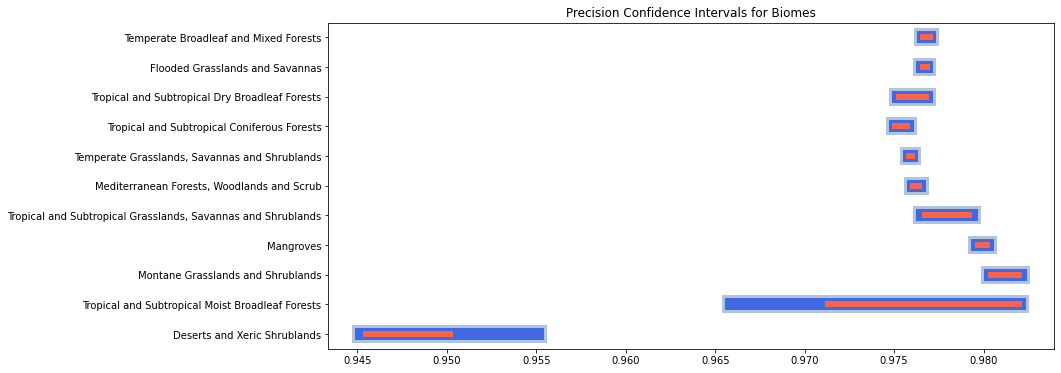

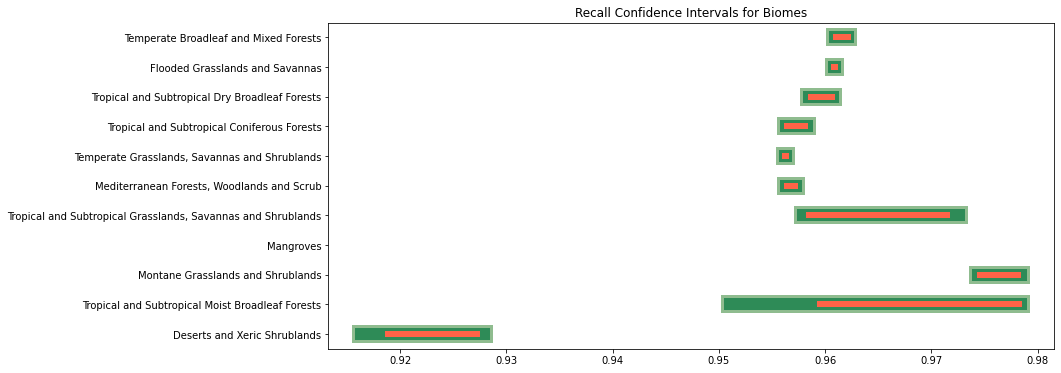

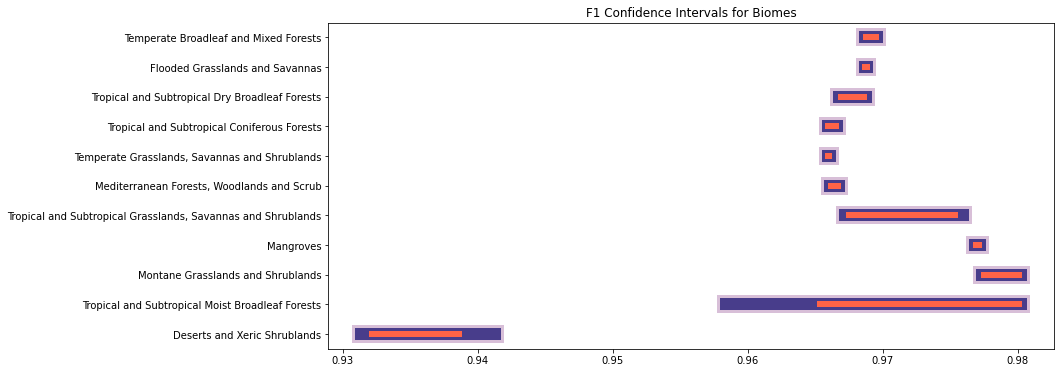

In [156]:
visualize_precision(biome_conf, 6, (13,6), 'Biomes')
visualize_recall(biome_conf, 6, (13,6), 'Biomes')
visualize_f1(biome_conf, 6, (13,6), 'Biomes')

### Subregion

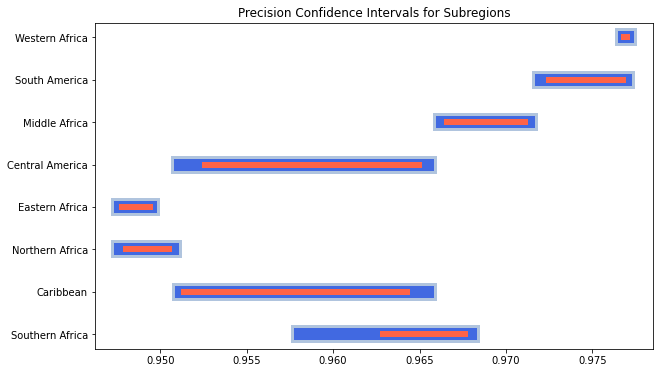

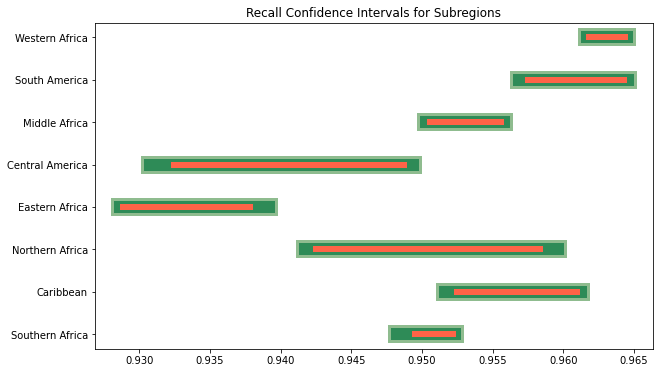

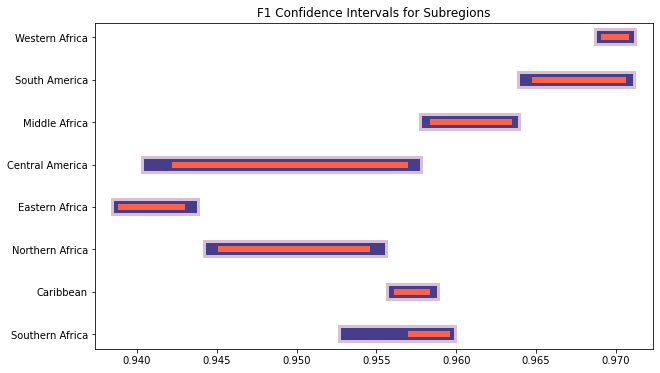

In [151]:
visualize_precision(subregion_conf, 6, (10,6), 'Subregions')
visualize_recall(subregion_conf, 6, (10,6), 'Subregions')
visualize_f1(subregion_conf, 6, (10,6), 'Subregions')

### Country Examples

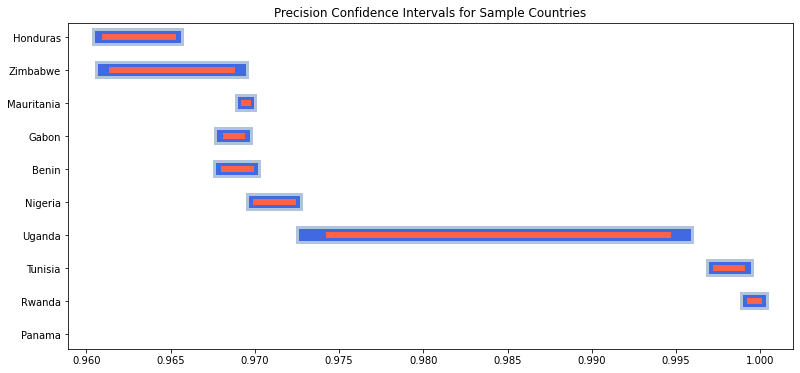

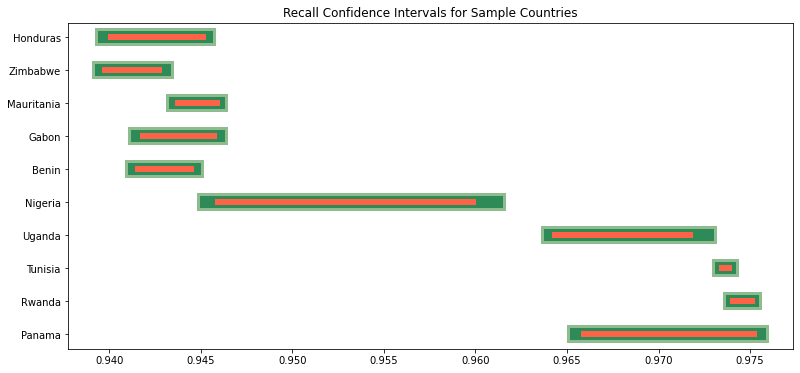

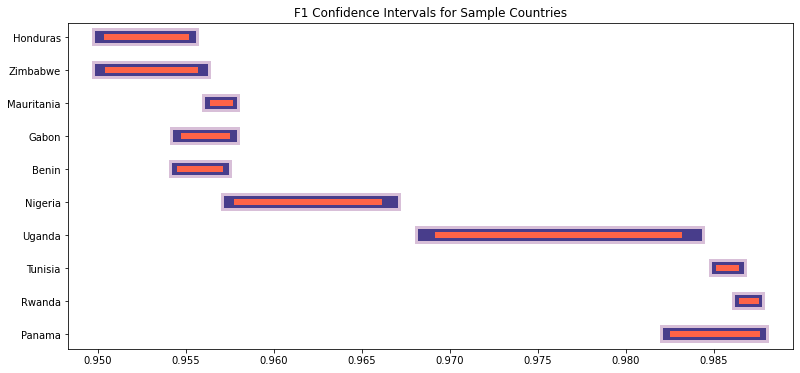

In [168]:
visualize_precision(country_conf[:10], 6, (13,6), 'Sample Countries')
visualize_recall(country_conf[:10], 6, (13,6), 'Sample Countries')
visualize_f1(country_conf[:10], 6, (13,6), 'Sample Countries')